## Fingerprint enhancement and minutia extraction

In this lab, we will dive into convolution, image filtering, gradients and keypoints using a fingerprint detection example. The standard fingerprint recognition process relies on a basic process: capture a clear image of a fingerprint, enhance it to clearly show ridges (fingerprint lines) and binarise (threshold to binary image), then detect minutia (fingerprint line intersections or end-points of ridges). The pattern formed by these minutia is unique, and can be used for fingerprint matching and recognition.

The accompanying images show a poor quality image of a fingerprint, taken from a foggy glass surface and a kettle. Fingerprint recognition from sources like these is called latent fingerprinting, but more challenging because we can't control the conditions the fingerprint is taken under. As part of the lab, we will losely follow the steps in this paper,

> Hong, L., Wan, Y., and Jain, A. K. Fingerprint image enhancement: Algorithm and performance evaluation. IEEE Transactions on Pattern Analysis and Machine Intelligence 20, 8 (1998), 777 789.

to improve the image quality. The basic steps outlined in this paper are, compute average gradient orientation in blocks in image. Use this gradient orientation to select Gabor filters to enhance ridges. Tune the frequency of the gabor filters to get a good response. Filter the image with these filters and combine repsonses to return an enhanced image. 

For your implementation of this, you are required to:

1. Load the image using opencv, convert it to grey scale, and crop to the region with the fingerprint.
2. Use the opencv `cv2.equalizeHist` function to improve image contrast.
3. Implement a convolution function called `my_conv` that takes in an image, a kernel or filter, and a stride, and returns the filtered image response. Your convolution function does not need to flip the kernel or perform padding. You may use the opencv conv2d function for filtering below instead, but this function won't be able to perform strided convolutions (needed below).
4. Compute the orientation of the gradient at each pixel in the image using Sobel filtering `cv2.Sobel` (see steps below).
      * First blur the image using a Gaussian kernel with a stride of 1 `cv2.GaussianBlur`.
      * Compute the horizontal and vertical Sobel derivatives respectively. Use matplotlib to show the output images.
      * Compute the gradient orientation using `atan2(Gy,Gx)`. Use matplotlib to show the output images, selecting a suitable colormap to make it easier to visualise.
      * Repeat the process above, using different size kernels and standard deviations. Choose a kernel size and standard deviation that helps pick up the gradient for the ridge lines and briefly motivate why you chose this. 
5. Design a convolutional kernel to divide the image into d x d pixel image patches and compute the average gradient orientation in each. Hint, use the stride parameter together with the averaging filter describe in the lecture videos to do this. Use `numpy.histogram` functions to compute a histogram of the orientations in this response image using k orientation bins. Use matplotlib to plot the histogram. You will need to come up with good choices for the numbers k and d. 
6. Use the gabor filter code provided to generate gabor filters for each of the orientations identified by the histogram above. Filter the image using these, and use matplotlib to show both the output images and filters. 
7. Combine all the filtered responses into a single image, by taking the maximum response at each pixel. Threshold the image to leave only those pixels greater than some threshold value. Plot the final enhanced image and try to tune the threshold value to result in the clearest fingerprint. Compare with (by plotting alongside) an approach that thresholds the original image only.   
8. Use a suitable corner detector in opencv to detect minutia (corners) in the thresholded image. Show the corners using matplotlib, and compare with corners detected directly on the original image.
9. Tune the hyperparameters (kernel size, thresholds, kernel parameters etc.) to try to get the best possible fingerprint and minutia. Try the same approach using the second image provided. Save the two best quality minutia images using the opencv `cv2.imwrite` function. Load both these images and use matplotlib to show the final results.
10. Write a brief report (max 600 words) discussing which parameters affect the fingerprint quality the most, and explaining the contribution of each step above. Explain your resoning by referencing the intermediate result figures you generated. Think about the image content and justify your choices of kernel sizes, standard deviations, frequencies, bin counts etc. Did the same parameters work for both images, explain why/ why not? What are some of the limitations of the approach above?

### Academic integrity

Every lab submission will be screened for any collusion and/or plagiarism. Breaches of academic integrity will be investigated thoroughly and may result in a zero for the assessment along with interviews with the plagiarism officers at Monash University.

### Late submissions

The default late submission university penalty will apply.

### Lab Instructions and the Use of Generative AI

You may not use any built-in opencv functions for this lab, other than those used for loading/ saving an image, extracting and matching keypoints, and
computing homographies.
* You may use NumPy for array handling, and vectorizing your code (reducing
the number of for-loops) is encouraged.
* You should use Matplotlib to display images and any intermediate results.
* You may use generative AI.

### Grading
Each lab is worth 8%, and there are a number of sections and tasks with their own weighting. A task is only considered complete if you can demonstrate a working program and show an understanding of the underlying concepts. Note that later tasks should reuse code from earlier tasks.

You will be marked based on:
* The degree to which you successfully followed the steps above and correctly implemented these.
* The quality of the fingerprint enhancement and minutia detection you finally obtained.
* The quality of your discussion and interpretation of the effects of the steps above and the choice of hyperparameters. Based on the minutia detected, comment on whether you think this method would work to recognise a fingerprint.


You may use generative AI/ coding assistance and built in opencv, matplotlib or numpy functions in this lab.

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

### Step 1: Load your image, convert to grey scale, crop and display it using matplotlib

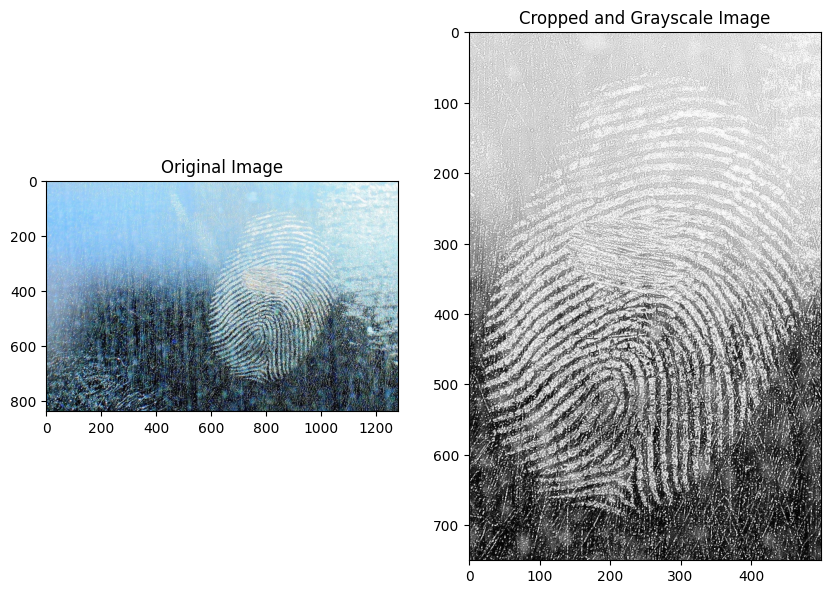

In [4]:
im_glass = cv2.imread('./glass.png') # Load in colour image
im_g = cv2.cvtColor(im_glass, cv2.COLOR_BGR2GRAY) #Make it grayscale
im_g = im_g[50:800, 570:1070]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im_glass)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(im_g, cmap='gray')
plt.title("Cropped and Grayscale Image")
plt.show()


### Step 2: Perform histogram equalisation and show the result using matplotlib

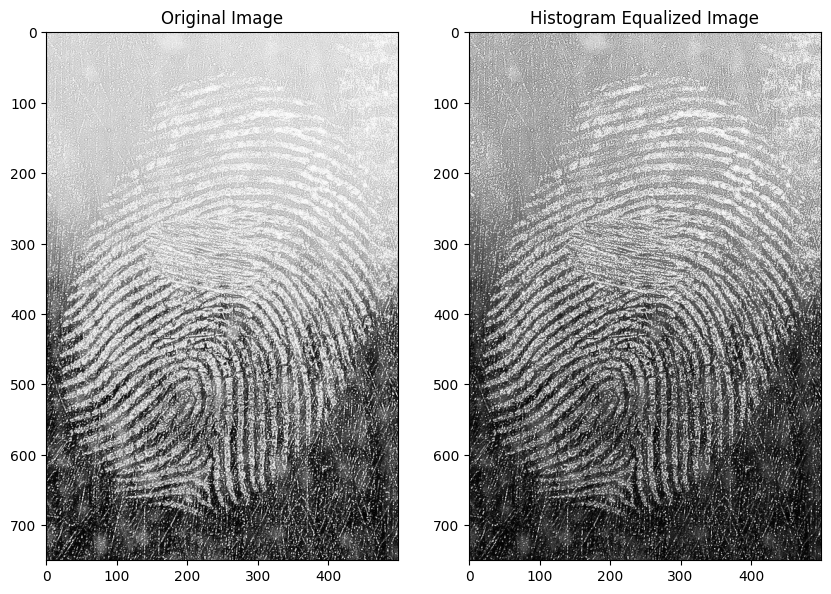

In [5]:
im_eq = cv2.equalizeHist(im_g) #Equalizing function
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im_g, cmap='gray')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(im_eq, cmap='gray')
plt.title("Histogram Equalized Image") 
plt.show()

### Step 3: Write your own strided convolution

In [ ]:
#We can use any kind of kernel for the convolution
def my_conv(image, kernel, stride):
    height_range = (image.shape[0]-kernel.shape[0])/stride + 1
    width_range = (image.shape[1]-kernel.shape[1])/stride + 1
    image_conv = np.zeros((image.shape[0], image.shape[1])) #initialize the convolved image
    for row in range(0, height_range):
        for col in range(0, width_range):
            image_conv[row, col] = np.sum(image[row:row+kernel.shape[0], col:col+kernel.shape[1]]*kernel)
    return image_conv




#### Step 4: Compute the orientation of the gradient at each pixel in the image using Sobel filtering

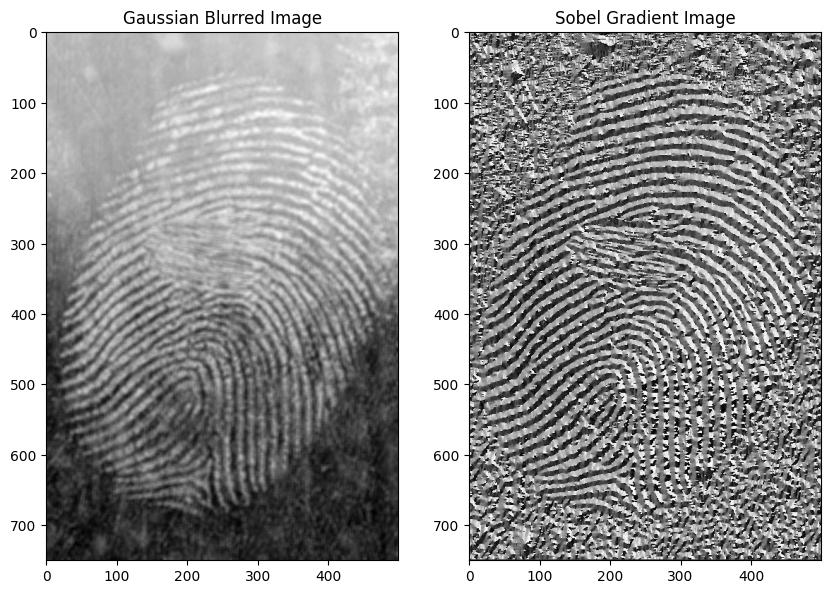

In [10]:
#Step 1: Add a gaussian blur to the image.
    # We can use a larger X sigma to blur out the noise, as this consists of horizontal streaks.
    # A kernel size of 15x15 worked well for this image.
im_gaus = cv2.GaussianBlur(im_eq, (7,7), sigmaX=3, sigmaY=3)
#Step 2: Apply the sobel operator to the image
im_grad_x = cv2.Sobel(im_gaus, cv2.CV_64F, 1, 0, ksize=3, borderType=cv2.BORDER_CONSTANT)
im_grad_y = cv2.Sobel(im_gaus, cv2.CV_64F, 0, 1, ksize=3, borderType=cv2.BORDER_CONSTANT)
im_sobel = np.arctan2(im_grad_y,im_grad_x)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im_gaus, cmap='gray')
plt.title("Gaussian Blurred Image")
plt.subplot(1,2,2)
plt.imshow(im_sobel, cmap='gray')
plt.title("Sobel Gradient Image")
plt.show()

#### Step 5: Compute the average orientation in image blocks and plot a histogram of the orientations

Text(0.5, 1.0, 'Histogram of Orientations')

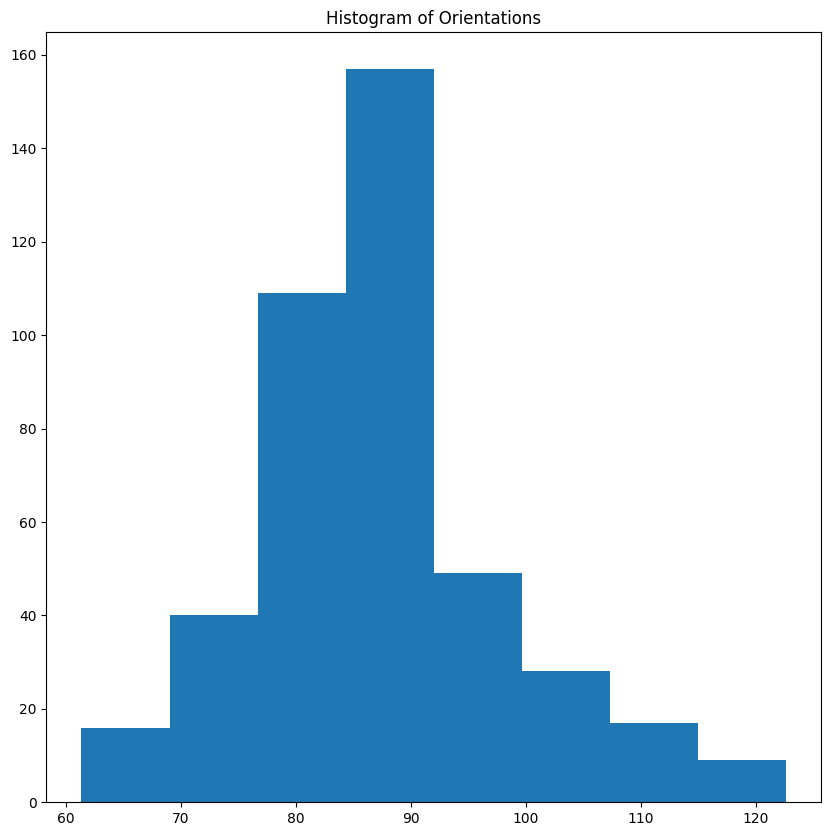

In [ ]:
#Divide the image into dxd patches.
k = 8 #Number of bins for the orientations
d = 30 #Patch size, and also the stride
# For each dxd patch, compute the average gradient orientation
# progress through each row and column, stepping by d each time and computing the gradient orientation for each patch
ave_orientations = np.array([])
all_orientations = np.array([])


for patch_row in range(0, im_gaus.shape[0], d):
    for patch_col in range(0, im_gaus.shape[1], d):
        grad_x = cv2.Sobel(im_gaus[patch_row:patch_row+d, patch_col:patch_col+d], cv2.CV_64F, 1, 0, ksize=3, borderType=cv2.BORDER_CONSTANT)
        grad_y = cv2.Sobel(im_gaus[patch_row:patch_row+d, patch_col:patch_col+d], cv2.CV_64F, 0, 1, ksize=3, borderType=cv2.BORDER_CONSTANT)
        orientations = np.rad2deg(np.arctan2(grad_y, grad_x)) % 180
        all_orientations = np.append(all_orientations, orientations)
        ave_orientation = np.mean(orientations)
        ave_orientations = np.append(ave_orientations, ave_orientation)
      
#Plot a histogram of the orientations

plt.figure(figsize=(10,10))
plt.hist(np.array(ave_orientations), bins=k)
plt.title("Histogram of Orientations")





#### Step 6: Generate gabor filters for each of the orientation bins above, apply these and use matplotlib to visualise both the filters and responses

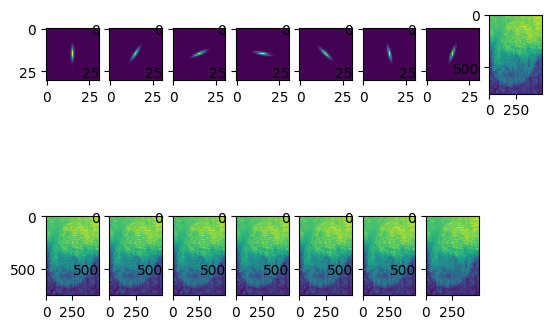

In [27]:
# Given to students.
def gabor(theta,ksize,sigma,freq):
    
    kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, 10.0, freq, 0, ktype=cv2.CV_64F)
    kern /= 1.0 * kern.sum() 
    
    return kern

bins = np.linspace(0, 180, k)

ksize = 31
sigma=0.5
freq=0.2


# Generate gabor filters for each orientation bin
gab_filters = []
filtered_image = []

for i in range(k):
    gabor_filter = gabor(bins[i], ksize, sigma, freq)
    gab_filters.append(gabor_filter)
    image = cv2.filter2D(im_gaus, cv2.CV_64F, gabor_filter)
    filtered_image.append(image)

for i in range(k):
    plt.subplot(2,8,i+1)
    plt.imshow(gab_filters[i])

for j in range(k):
    plt.subplot(2,8,j+8)
    plt.imshow(filtered_image[j])

        
        


#Now we apply the filters to the image



#### Step 7: Combine the responses above and show the enhanced image alonside the original one, then threshold the image to retain only fingerprint information

Text(0.5, 1.0, 'Enhanced Image')

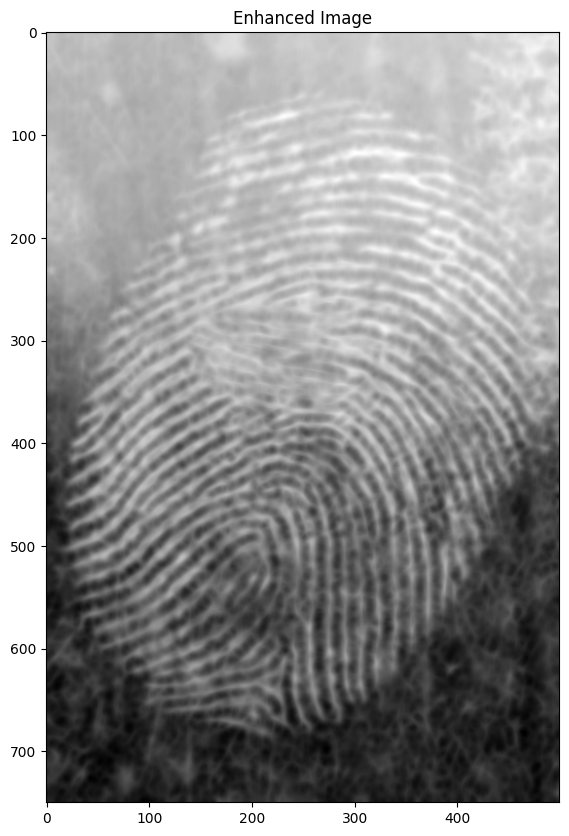

In [29]:
# Check each image in the pixel:
enhanced_im = np.zeros(im_gaus.shape)
for row in range(im_gaus.shape[0]):
    for col in range(im_gaus.shape[1]):
        #Identify which image has the highest response
        max_resp = 0
        for i in range(k):
            if filtered_image[i][row, col] > max_resp:
                max_resp = filtered_image[i][row, col]
        enhanced_im[row, col] = max_resp
plt.figure(figsize=(10,10))
plt.imshow(enhanced_im, cmap='gray')
plt.title("Enhanced Image")
            


#### Step 8: Use a corner detector to try to identify Minutia

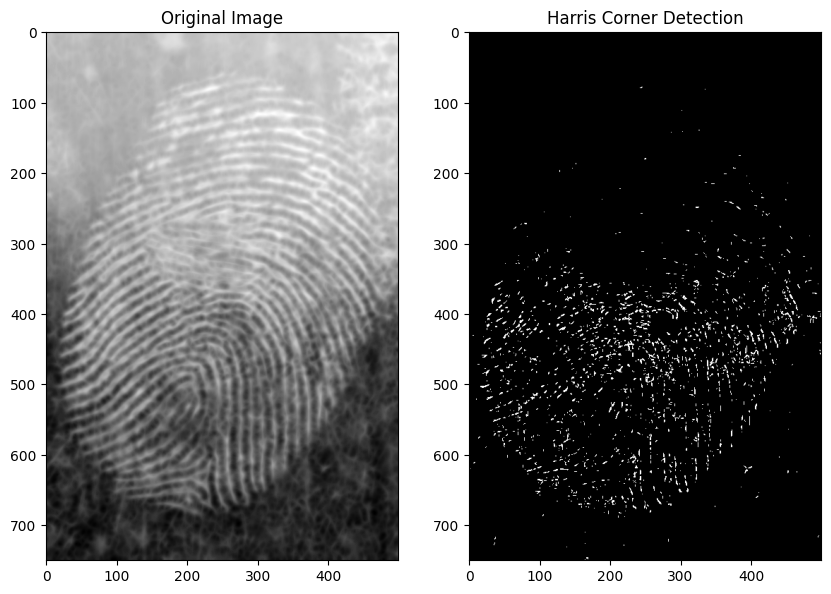

In [42]:
# we can do harris corner detection on the enhanced image

# Ensure the enhanced image is in the correct format
enhanced_im_float32 = np.float32(enhanced_im)

# Perform Harris corner detection
harris_corners = cv2.cornerHarris(enhanced_im_float32, 2, 3, 0.03)
# Do a threshold
harris_corners = harris_corners>0.04*harris_corners.max()

corners_x, corners_y = np.where(harris_corners)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(enhanced_im, cmap='gray')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(harris_corners, cmap='gray')
plt.title("Harris Corner Detection")
plt.show()

#### Step 9: Tune the hyperparameters to find the best enhanced image and best minutia detection for each images, load and show these images below.

#### Step 10: Discussion

## Discussion

### Parameters
- The factor which greatly affects the quality of the final enhanced image are the sizes of kernels used. A gaussian kernel which is the right size can blur out a lot of the background noise in an image, but if it is too large, then the edges between fingerprint ridges can be blurred. 
- In order to get the best enhanced image, blurring out the background noise and then increasing the contrast for clear edge detection is important.
- As such, the first important parameter to identify is the correct amount of blurring. 
- Something which made edge detection difficult for the glass.png image is that there is a highlight due to the reflectivity of the glass. This has the effect of decreasing the contrast between edges in that area. In the final minutia detection image, many of these corners are missed. This complicated the enhancement of the image because reducing the threshold gradient allows more noise into the final image.
### Potential improvements
- If one was implementing a fingerprint detection database, it could be helpful to have different processing algorithms for different kinds of fingerprints. Some people have "arch" style fingerprints, where most edges run horizontally- in these cases, we can bias the algorithm towards detecting edges with orientations pointing this way, or by using  a Gaussian kernel with different dimensions. For other kinds of fingerprints such as "whorl" fingerprints, a more dimensionally symetric approach would be better suited.
